# Herron Topic 6 - Practice (Monday 2:45 PM, Section 3)

## Announcements

- Quiz 6 mean and median were about ~~90% and 96%~~  92% and 100%
    - Please see the solution on Canvas and let me know if you have any questions
    - Gradescope shows which hidden tests you missed
    - I recently widened the tolerance on two hidden tests to give full credit if you minimized variance instead of volatility
- I posted [project 2](project_02.ipynb) about Bitcoin and gold as inflation and market risk hedges
- Next week (week of 4/10) is the assessment exam
    - MSFQ students must take it for 5% of overall course grade 
    - Non-MSQF students do not take it and weight their grades by only 95%
    - 20 multiple choice questions on the 6 core courses (corporate finance, investments, math, data analytics, empirical methods, and derivatives)
    - ***You must be in the classroom during your assigned date and time to take the MSFQ assessment exam***
    - If there is interest, we will discuss five stylized facts of asset returns after the MSFQ assessment exam
    - We will also have our final quiz, quiz 7
- The following week (week of 4/17) we will discuss Herron topic 5 (simulations)
    - I will record a lecture video and complete a practice notebook
    - But we will reserve class time for group work
    - The class voted about 2-to-1 not to drop a topic, so this is a compromise, given that Monday is Patriot's Day holiday
- The following week (week of 4/24) we will reserve class time for group work
    - Project 2 is due Wednesday, 4/26, at 11:59 PM
    - Teammates Review 2 is due Wednesday, 4/26, at 11:59 PM
    - 30,000 DataCamp XP are due Friday, 4/28, at 11:59 PM
- ***Somewhere in there, please reserve 10 minutes to complete a TRACE review for this course***
    - I cannot make you complete TRACE reviews
    - But they are very helpful
    - I change my courses every semester, hopefully for the better, based on TRACE reviews

##  Practice

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

### Reimplement the equal-weighted momentum investing strategy from the lecture notebook

Try to use a few cells and temporary variables as you can (i.e., perform calculations inside `pd.concat()`).

In [4]:
crsp = (
    pd.read_csv(
        filepath_or_buffer='crsp.csv',
        parse_dates=['date'],
        na_values=['A', 'B', 'C'] # we can ignore returns coded as A, B, or C
    )
    .assign(
        date=lambda x: x['date'].dt.to_period(freq='M'), # I prefer periods to dates for monthly data
        ME=lambda x: x['PRC'].abs() * x['SHROUT'] # market value of equity in thousands of dollars
    )
    .rename_axis(columns='Variable')
    .set_index(['PERMNO', 'date'])
)

Please the [Herron Topic 6 lecture notebook](herron_06_lecture.ipynb) for variable definitions.

In [5]:
crsp.head()

Variable        SHRCD     PRC     RET    SHROUT         ME
PERMNO date                                               
10000  1986-01     10 -4.3750     NaN 3680.0000 16100.0000
       1986-02     10 -3.2500 -0.2571 3680.0000 11960.0000
       1986-03     10 -4.4375  0.3654 3680.0000 16330.0000
       1986-04     10 -4.0000 -0.0986 3793.0000 15172.0000
       1986-05     10 -3.1094 -0.2227 3793.0000 11793.8783

In [6]:
crsp.describe()

Variable,SHRCD,PRC,RET,SHROUT,ME
count,3794898.0000,3692827.0000,3664978.0000,3791120.0000,3692827.0000
mean,10.7392,31.8232,0.0115,44254.7485,1822175.8177
std,0.4390,1835.1071,0.1799,249579.2094,16811017.1404
min,10.0000,-1832.5000,-0.9957,0.0000,0.0000
25%,10.0000,1.8750,-0.0648,2288.0000,16949.2500
50%,11.0000,11.0000,0.0000,7336.0000,73164.0000
75%,11.0000,25.8000,0.0700,25600.0000,403080.1875
max,11.0000,528921.0000,24.0000,29206400.0000,2902368140.5592


To implement a momentum strategy, we need:

1. 1-month returns, which are the returns we receive for each holding period
1. 11-month returns, which are the returns (from month -12 to month -2) that we use to rank stocks and assign to momentum portfolios
1. Momentum portfolio assignments based on 11-month trailing returns

In [7]:
ret_1m = crsp['RET'].unstack('PERMNO')

There is not a `.prod()` method for `.rolling()`, so the fastest way to calculate 11-month rolling returns is to:

1. Convert simple returns to log returns with `.pipe(np.log1p)`
1. Calculate 11-month rolling *log* returns with `.rolling(11).sum()`
1. Convert log returns to simple returns with `.pipe(np.expm1)`

In [8]:
ret_11m = ret_1m.pipe(np.log1p).rolling(11).sum().pipe(np.expm1)

Then we use `pd.qcut()` to assign `ret_11m` to ten momentum portfolios.
Here is a simple example:

In [9]:
pd.qcut(x=np.arange(20), q=10, labels=False)

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9])

Here are the momentum portfolios:

In [10]:
port_11m = ret_11m.dropna(how='all').apply(pd.qcut, q=10, labels=False, axis=1)

Short-term reversal, momentum, and long-term reversal represent distinct aspects of asset price behavior that have been observed and documented in the financial markets. As a researcher, I am particularly interested in understanding the underlying factors that contribute to these market anomalies and their implications for trading strategies and portfolio management.

Short-term reversal captures the tendency of asset prices to reverse direction in a brief period, typically days to weeks. This phenomenon can be associated with market overreactions to news events, temporary liquidity constraints, or other transient factors. Astute investors may capitalize on these short-term reversals by adopting a contrarian approach, buying assets that have recently underperformed and selling those that have outperformed.

Momentum represents the persistence of asset price trends over a short to medium-term horizon, typically ranging from 3 to 12 months. This market anomaly suggests that assets with strong recent performance continue to outperform, while poorly performing assets continue to underperform. Momentum can be linked to factors such as investors' behavioral biases, positive feedback trading, and herd mentality. To exploit momentum, investors may adopt a trend-following strategy, buying assets with strong recent performance and selling those with weak performance.

Long-term reversal, often referred to as mean reversion, is the tendency of asset prices to revert to their long-term average or fundamental value over an extended period, typically several years. This phenomenon is thought to result from market participants gradually recognizing and correcting mispricing, leading to price adjustments. Investors following a long-term reversal strategy may focus on assets with extreme valuation levels, buying undervalued assets and selling overvalued ones, with the expectation that prices will eventually revert to their long-term mean.

***To avoid short-term reversal, we skip one month between 11-month returns and portfolio formation.***

In [11]:
mom = (
    pd.concat(
        objs=[
            ret_1m, # holding period return
            ret_11m.shift(2), # trailing returns
            port_11m.shift(2), # portfolio assignment based on trailing return
            crsp['ME'].unstack('PERMNO').shift(1) # beginning-of-month market value of equity
        ],
        keys=['Return', 'Trailing Return', 'Portfolio', 'Trailing ME'],
        names=['Variable'],
        axis=1
    )
    .stack('PERMNO')
    .dropna()
    .assign(Portfolio=lambda x: x['Portfolio'].astype(int) + 1)
)

In [12]:
mom_ew = (
    mom
    .groupby(['date', 'Portfolio'])
    ['Return']
    .mean() # simple mean is an equal-weighted portfolio return
    .unstack('Portfolio')
    .add_prefix('Mom ') # simplifies regression specifications below
)

In [13]:
mom_ew.head()

Portfolio,Mom 1,Mom 2,Mom 3,Mom 4,Mom 5,Mom 6,Mom 7,Mom 8,Mom 9,Mom 10
date,,,,,,,,,,
1927-01,-0.0006,0.0149,0.0425,0.0378,0.0009,0.0150,0.0124,0.0076,-0.0044,0.0126
1927-02,0.0641,0.0484,0.0866,0.0745,0.0436,0.0547,0.0561,0.0403,0.0579,0.0541
1927-03,-0.0530,-0.0381,-0.0243,-0.0408,-0.0192,-0.0201,0.0097,-0.0084,-0.0058,0.0012
1927-04,0.0230,-0.0085,-0.0054,-0.0061,0.0002,-0.0032,0.0138,0.0030,0.0323,0.0421
1927-05,0.0069,0.0353,0.0604,0.0536,0.0700,0.0950,0.0796,0.0838,0.0803,0.0886


We see a (nearly) monotonic relation between momentum portfolios (based on trailing 11-month returns) and holding period returns!

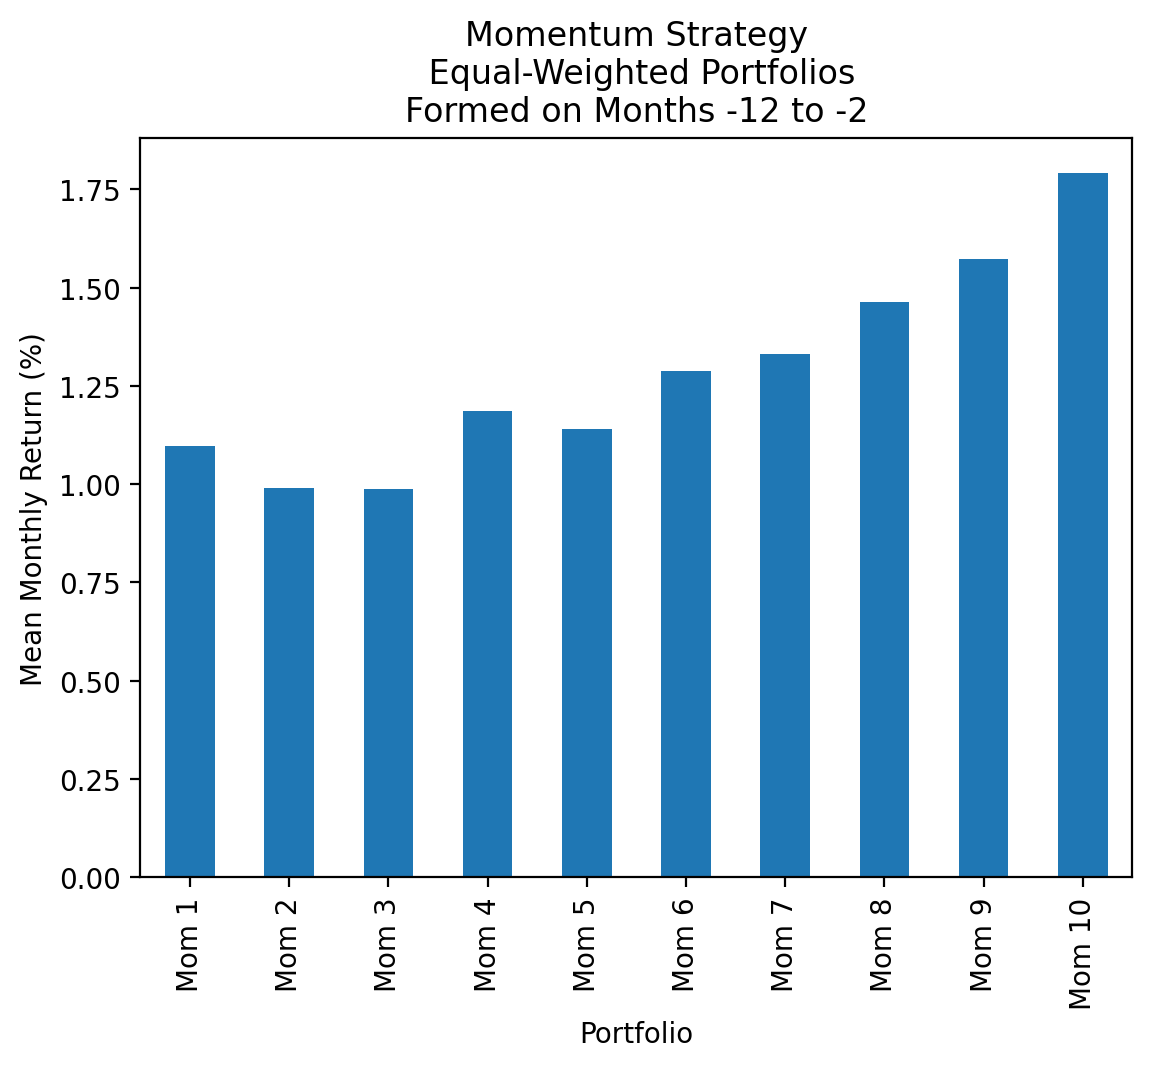

In [14]:
mom_ew.mean().mul(100).plot(kind='bar')
plt.ylabel('Mean Monthly Return (%)')
plt.title('Momentum Strategy\n Equal-Weighted Portfolios\nFormed on Months -12 to -2')
plt.show()

This relation is stronger when we consider long-term, buy-and-hold returns!

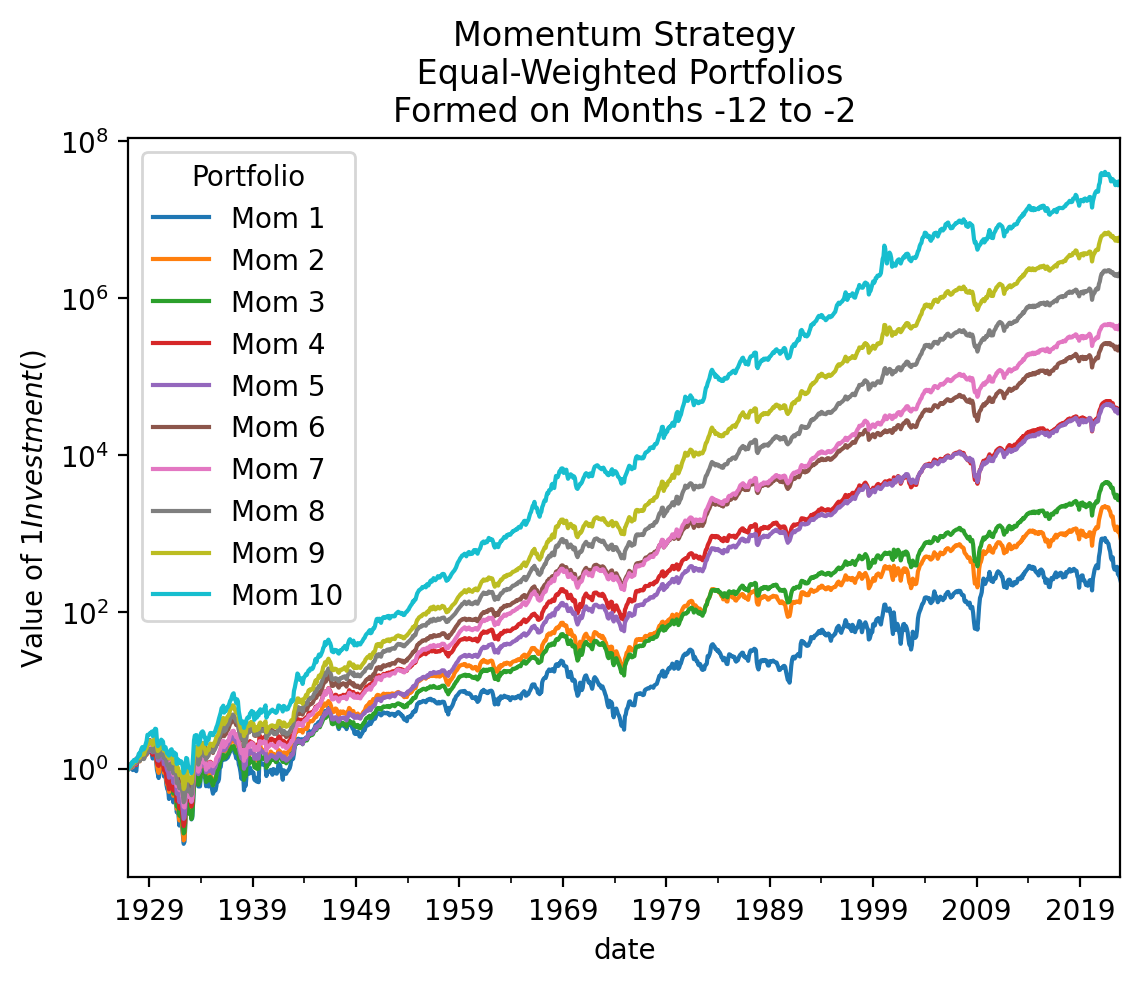

In [15]:
mom_ew.add(1).cumprod().plot()
plt.semilogy()
plt.ylabel('Value of $1 Investment ($)')
plt.title('Momentum Strategy\n Equal-Weighted Portfolios\nFormed on Months -12 to -2')
plt.show()

### Add a long-short portfolio that is long portfolio 10 and short portfolio 1

Call this long-short portfolio UMD.
What are the best and worst months for portfolios 1, 10, and UMD?

In [16]:
mom_ew = mom_ew.assign(UMD=lambda x: x['Mom 10'] - x['Mom 1'])

The worst month for the long-short portfolio is during the Great Depression.

In [17]:
mom_ew['UMD'].idxmin()

Period('1932-08', 'M')

Momentum strategies appear to generate large absolute returns.
However, long-short momentum strategies are occasionally wiped out by large market recoveries, that the short side of the portfolio does not survive in practice.
During downturns, the short side of the portfolio (i.e., the loser stocks) has a high beta.
When the market unexpectedly and quickly recovers, the exaggerated recovery in the high-beta stocks wipes out the long-short portfolio.
For example, if we invest $1 in the long-short portfolio at the end of 1929, the long-short portfolio is effectively wiped out during August 1932.

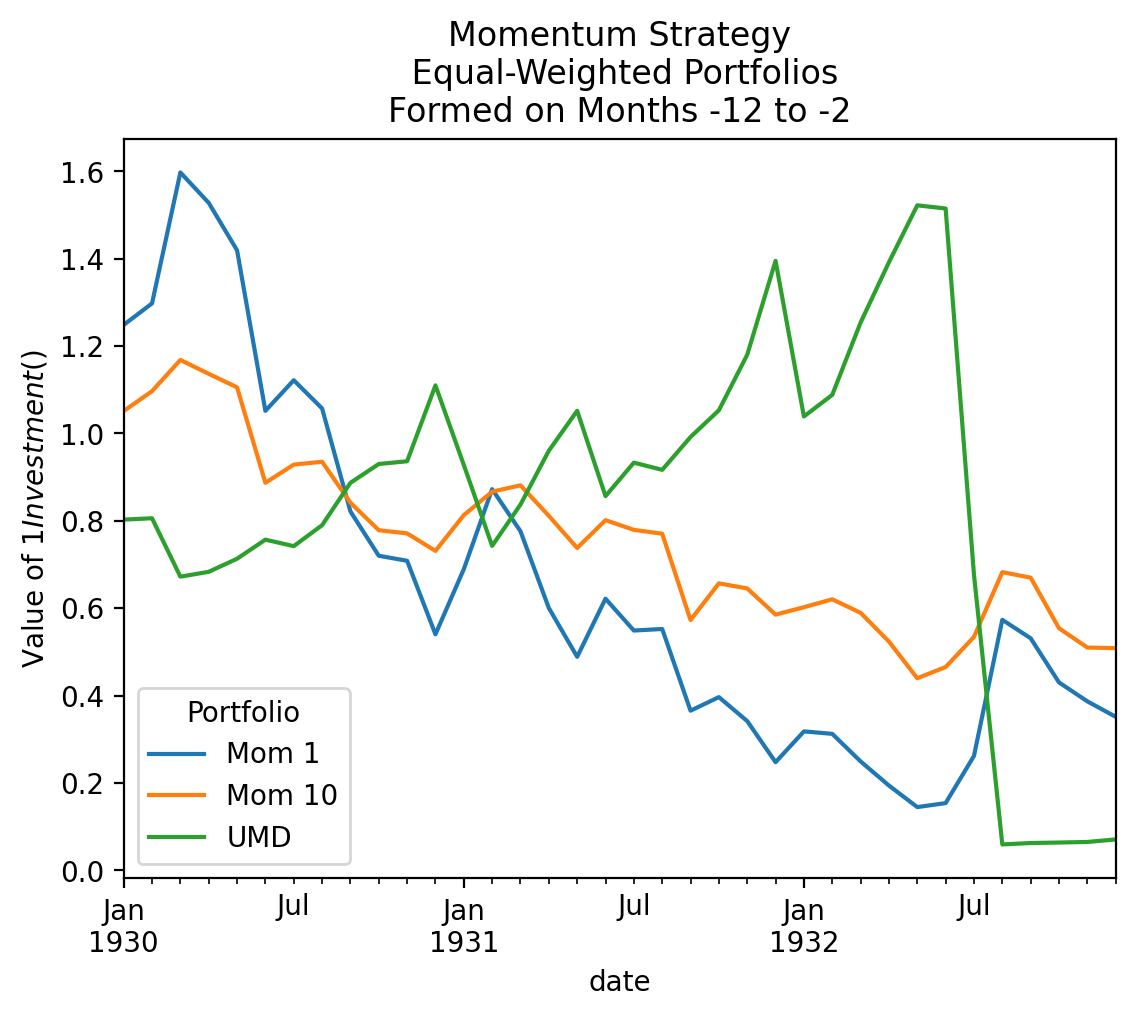

In [18]:
mom_ew.loc['1930':'1932', ['Mom 1', 'Mom 10', 'UMD']].add(1).cumprod().plot()
plt.ylabel('Value of $1 Investment ($)')
plt.title('Momentum Strategy\n Equal-Weighted Portfolios\nFormed on Months -12 to -2')
plt.show()

### What are the CAPM and FF4 alphas for these equal-weighted portfolios?

In [19]:
import statsmodels.formula.api as smf

***After class, I made the following code more repeatable.***

In [20]:
def capm(df, c):
    return smf.ols(formula=f'I(Q("{c}")-RF) ~ Q("Mkt-RF")', data=df)

In [21]:
ff_0 = pdr.DataReader(
    name='F-F_Research_Data_Factors',
    data_source='famafrench',
    start='1900',
    session=session
)

In [22]:
ff_mom = pdr.DataReader(
    name='F-F_Momentum_Factor',
    data_source='famafrench',
    start='1900',
    session=session
)

ff_mom[0].columns = ['Mom'] # we need to rename the Mom factor to remove leading and trailing whitespace

The `get_coefs()` function accepts a data frame of returns and factors data, a factor model regression function name, and number $n$ for the first $n$ columns in the data frame.
The factor model regression function must return a statsmodel model.
The `get_coefs()` function returns a data frame of coefficient estimates and standard errors.
We can use the `get_coefs()` function to quickly apply a factor model regression function.

In [23]:
def get_coefs(df, fun, n):
    models = [df.pipe(fun, c) for c in df.columns[:n]]
    fits = [m.fit() for m in models]
    coefs = (
        pd.concat(
            objs=[f.params for f in fits],
            axis=1,
            keys=df.columns[:10]
        )
        .transpose()
        .rename_axis(index='Portfolio', columns='Variable')
    )

    ses = (
        pd.concat(
            objs=[f.bse for f in fits],
            axis=1,
            keys=df.columns[:10]
        )
        .transpose()
        .rename_axis(index='Portfolio', columns='Variable')
    )

    return pd.concat(
        objs=[coefs, ses], 
        keys=['Coef', 'SE'], 
        names=['Statistic'], 
        axis=1
    )

The `plot_alpha()` function accepts the output of the `get_coefs()` function and plots portfolio alphas.

In [24]:
def plot_alpha(df):
    _ = df.swaplevel(axis=1)['Intercept']
    _['Coef'].plot(kind='bar', yerr=_['SE'])
    plt.ylabel('Monthly Alpha (%)')


We can look at the output of `get_coefs()`, but I typically will chain these functions.

In [25]:
mom_ew.mul(100).join(ff_0[0]).pipe(get_coefs, fun=capm, n=10)

Statistic      Coef                    SE            
Variable  Intercept Q("Mkt-RF") Intercept Q("Mkt-RF")
Portfolio                                            
Mom 1       -0.2642      1.6488    0.2364      0.0438
Mom 2       -0.2485      1.4625    0.1550      0.0287
Mom 3       -0.1499      1.3130    0.1170      0.0216
Mom 4        0.0747      1.2729    0.1071      0.0198
Mom 5        0.1002      1.1657    0.0874      0.0162
Mom 6        0.2728      1.1267    0.0786      0.0146
Mom 7        0.3420      1.0899    0.0778      0.0144
Mom 8        0.4860      1.0698    0.0794      0.0147
Mom 9        0.5828      1.0881    0.0882      0.0163
Mom 10       0.7466      1.1711    0.1273      0.0236

The beauty of chaining these functions is:

1. We have all calculations in one cell, eliminating the need to track many "off screen" calculations in other cells
1. We do not create intermediate data frames, eliminating the need to name and track many data frames

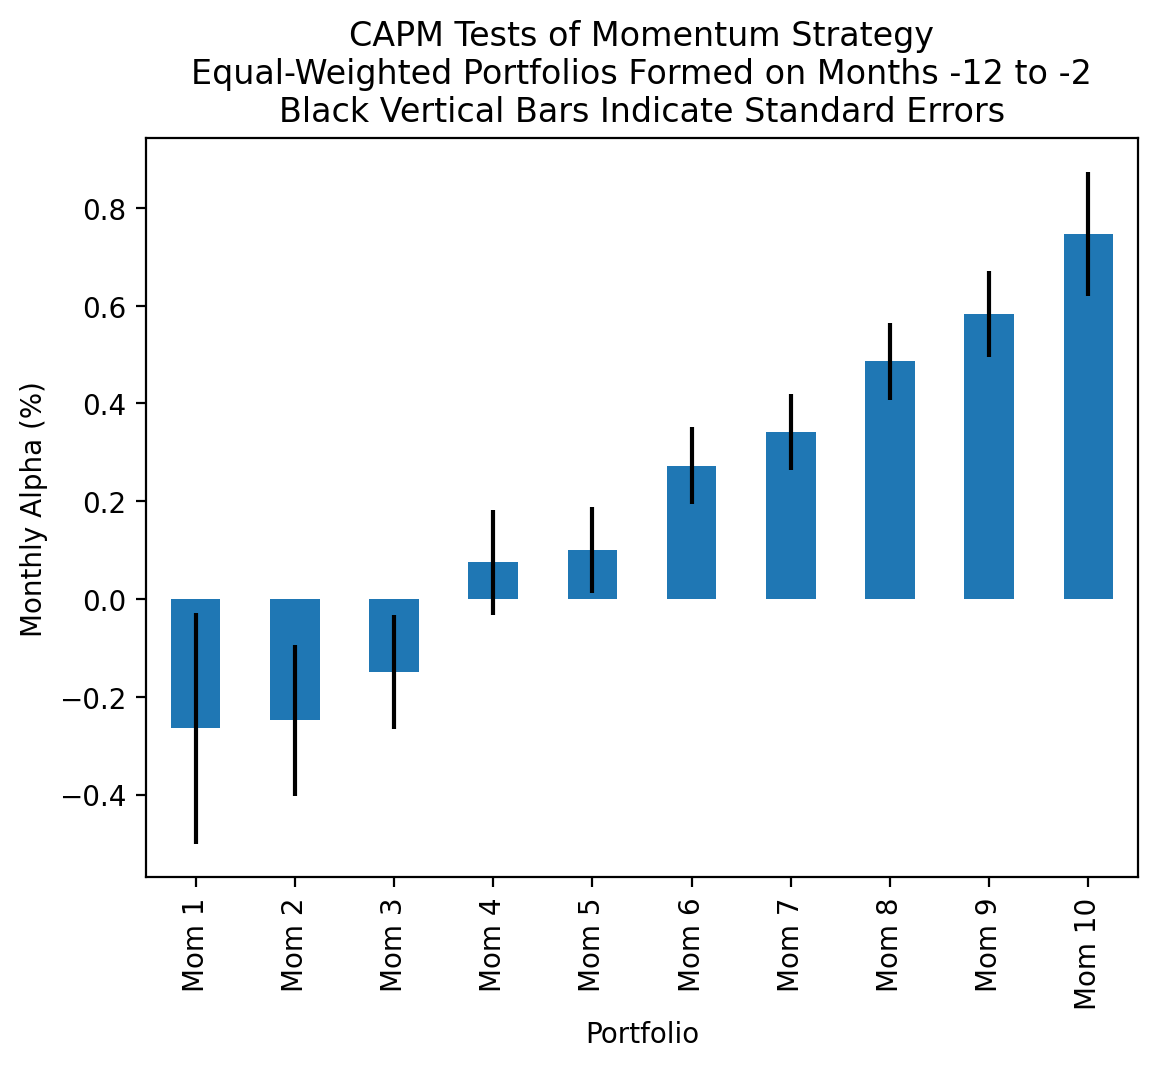

In [26]:
mom_ew.mul(100).join(ff_0[0]).pipe(get_coefs, fun=capm, n=10).pipe(plot_alpha)
plt.title(
    'CAPM Tests of Momentum Strategy' +
    '\nEqual-Weighted Portfolios Formed on Months -12 to -2' +
    '\nBlack Vertical Bars Indicate Standard Errors'
)
plt.show()

The momentum strategy has a large, positive, statistically significant alpha, suggesting it is a source of risk-adjusted returns (i.e., returns not associated with risk).
However, we saw above that momentum occasionally crashes, suggesting that the momentum strategy has risk.
We will investigate this with the Fama-French Four-Factor model, which add size, value, and momentum factors.
Once we consider SMB, HML, and Mom risk factors, we see:

1. The relation between returns and momentum portfolios is much weaker and not monotonic
1. The statistical significance of the alpha coefficient estimates is much lower.

In [27]:
def ff4(df, c):
    return smf.ols(formula=f'I(Q("{c}")-RF) ~ Q("Mkt-RF") + SMB + HML + Mom', data=df)

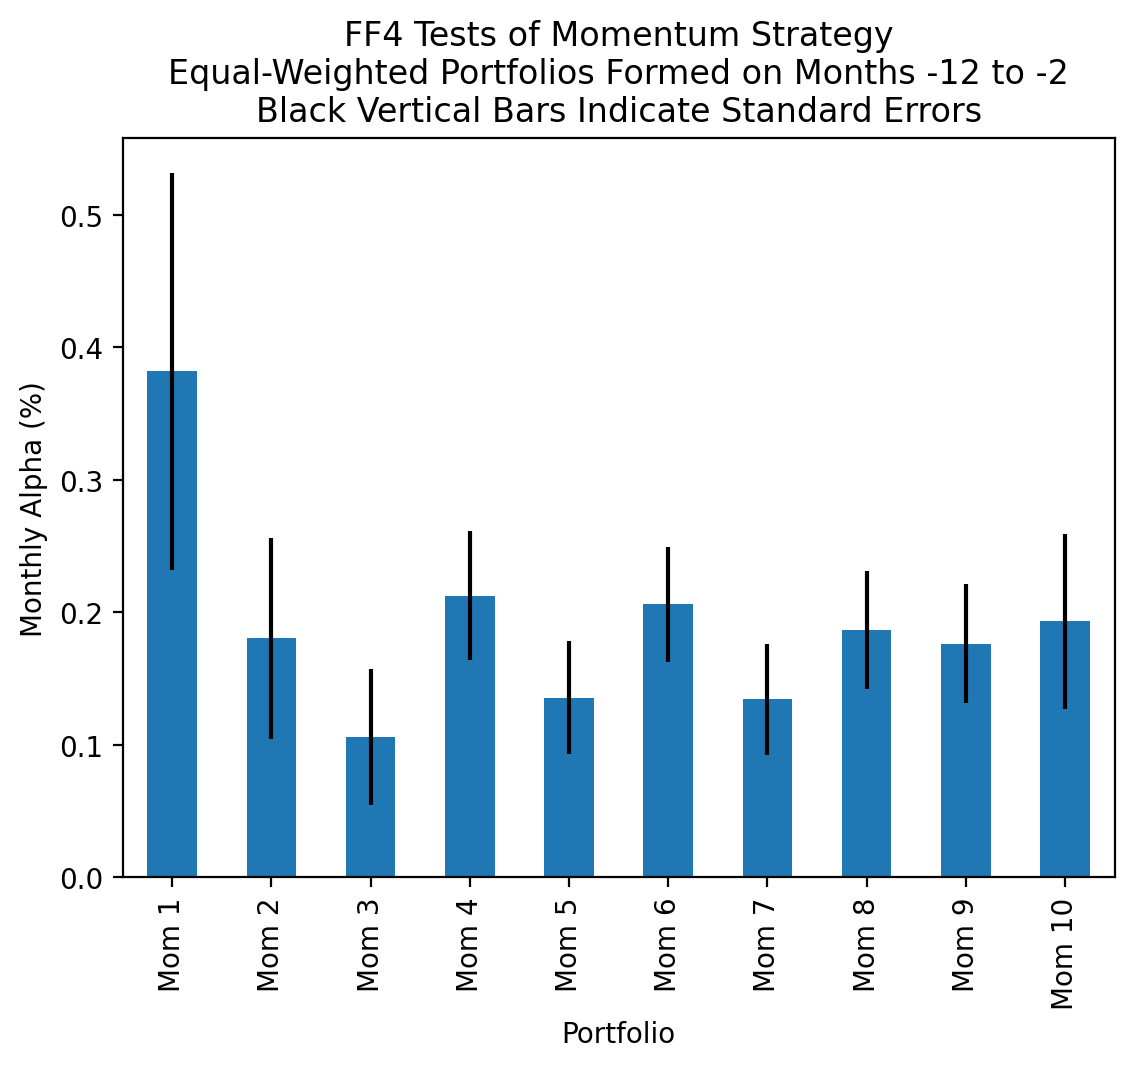

In [28]:
mom_ew.mul(100).join([ff_0[0], ff_mom[0]]).pipe(get_coefs, fun=ff4, n=10).pipe(plot_alpha)
plt.title(
    'FF4 Tests of Momentum Strategy' +
    '\nEqual-Weighted Portfolios Formed on Months -12 to -2' +
    '\nBlack Vertical Bars Indicate Standard Errors'
)
plt.show()

A more extreme test is to only consider the last 20 years of returns.

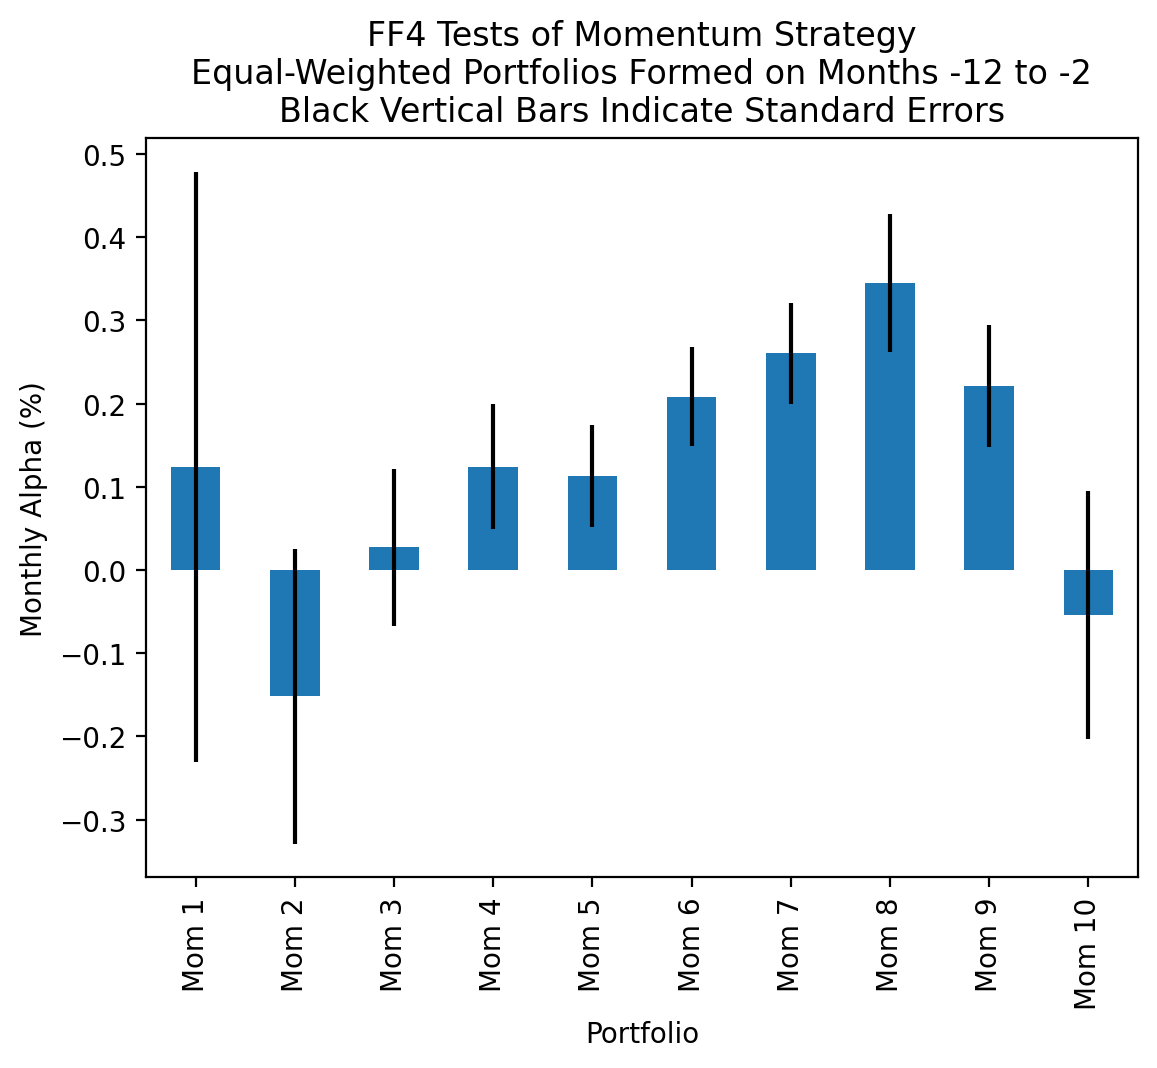

In [29]:
mom_ew.mul(100).join([ff_0[0], ff_mom[0]]).iloc[-240:].pipe(get_coefs, fun=ff4, n=10).pipe(plot_alpha)
plt.title(
    'FF4 Tests of Momentum Strategy' +
    '\nEqual-Weighted Portfolios Formed on Months -12 to -2' +
    '\nBlack Vertical Bars Indicate Standard Errors'
)
plt.show()

### What are the Sharpe Ratios on these 11 portfolios?

In [30]:
def sharpe(r, tgt, ppy):
    er = r.sub(tgt).dropna()
    return np.sqrt(ppy) * er.mean() / er.std()

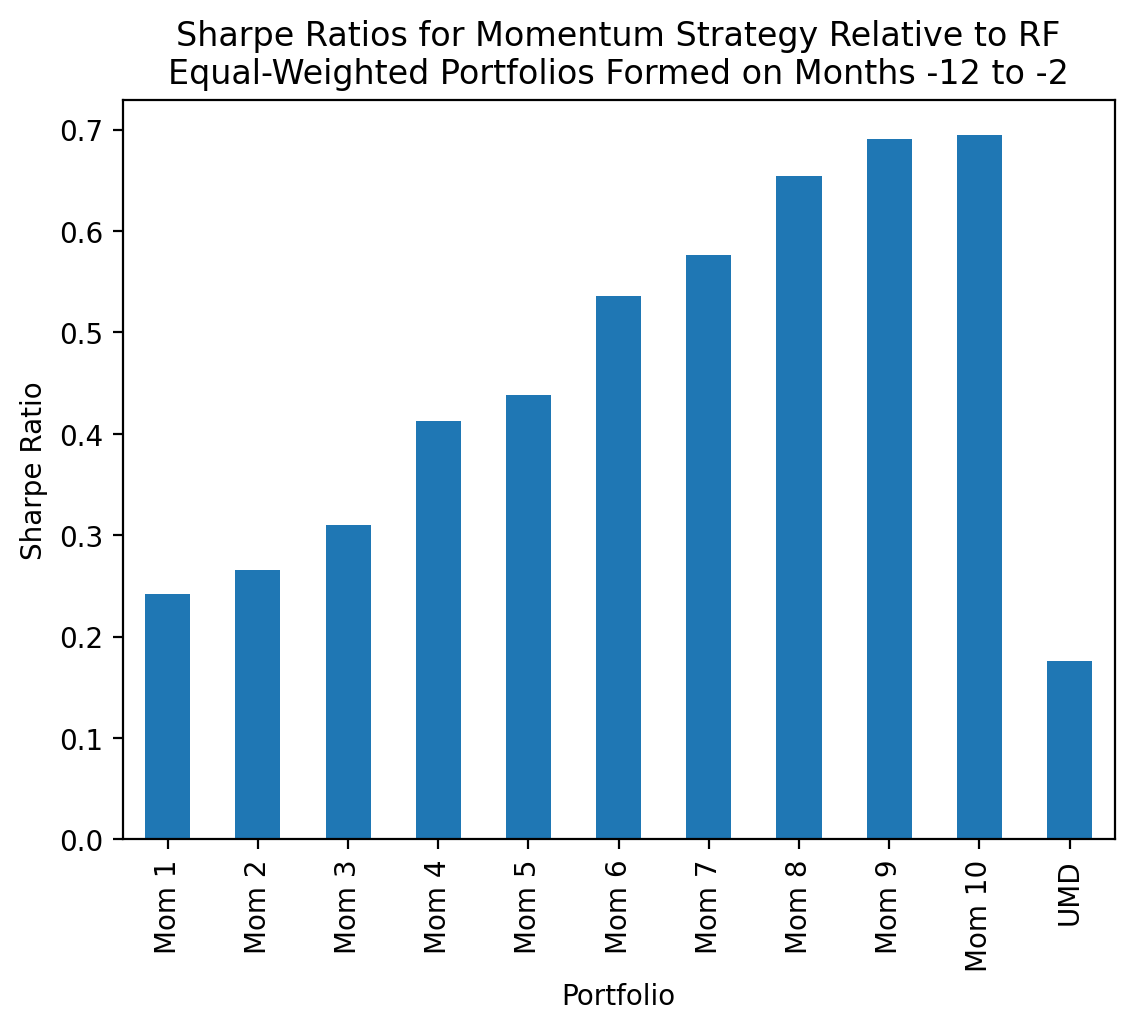

In [31]:
mom_ew.mul(100).apply(sharpe, tgt=ff_0[0]['RF'], ppy=12).plot(kind='bar')
plt.ylabel('Sharpe Ratio')
plt.title(
    'Sharpe Ratios for Momentum Strategy Relative to RF' +
    '\nEqual-Weighted Portfolios Formed on Months -12 to -2'
)
plt.show()

### Implement a value-weighted momentum investing strategy

Assign this strategy to data frame `mom_vw`, and include long-short portfolio UMD

We can replace the `.mean()` method, which calculates simple means (i.e., equal-weighted means), with the `.apply()` method and `np.average()` function, which has a `weights=` argument and calculates weighted means.
We weight portfolio returns by the beginning-of-month marker value of equity in the `Trailing ME` column.

In [32]:
mom_vw = (
    mom
    .groupby(['date', 'Portfolio'])
    .apply(lambda x: np.average(a=x['Return'], weights=x['Trailing ME']))
    .unstack('Portfolio')
    .add_prefix('Mom ')
)

### What are the CAPM and FF4 alphas for these value-weighted portfolios?

The alphas for the value-weighted momentum portfolios are generally smaller in magnitude than for the equal-weighted momentum portfolios.
Equal-weighted portfolios over-weight small stocks relative to value-weighted portfolios, and we expect most anomalies to be stronger in small stocks because small stocks are more difficult for institutional investors to  invest in at scale.

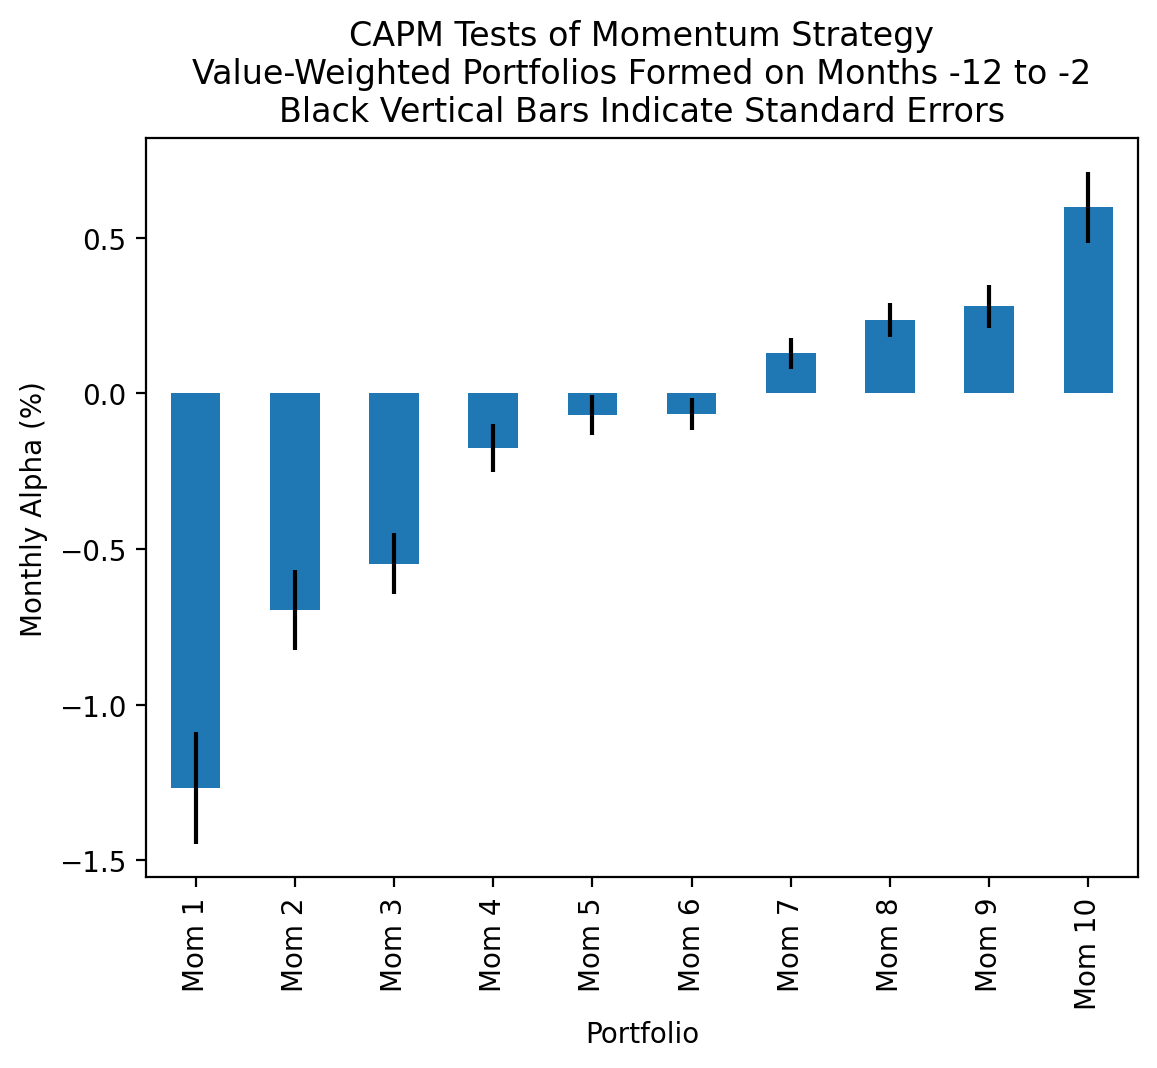

In [33]:
mom_vw.mul(100).join(ff_0[0]).pipe(get_coefs, fun=capm, n=10).pipe(plot_alpha)
plt.title(
    'CAPM Tests of Momentum Strategy' +
    '\nValue-Weighted Portfolios Formed on Months -12 to -2' +
    '\nBlack Vertical Bars Indicate Standard Errors'
)
plt.show()

The momentum strategy falls apart once we consider the Fama-French Four-Factor model with value-weighted portfolios.

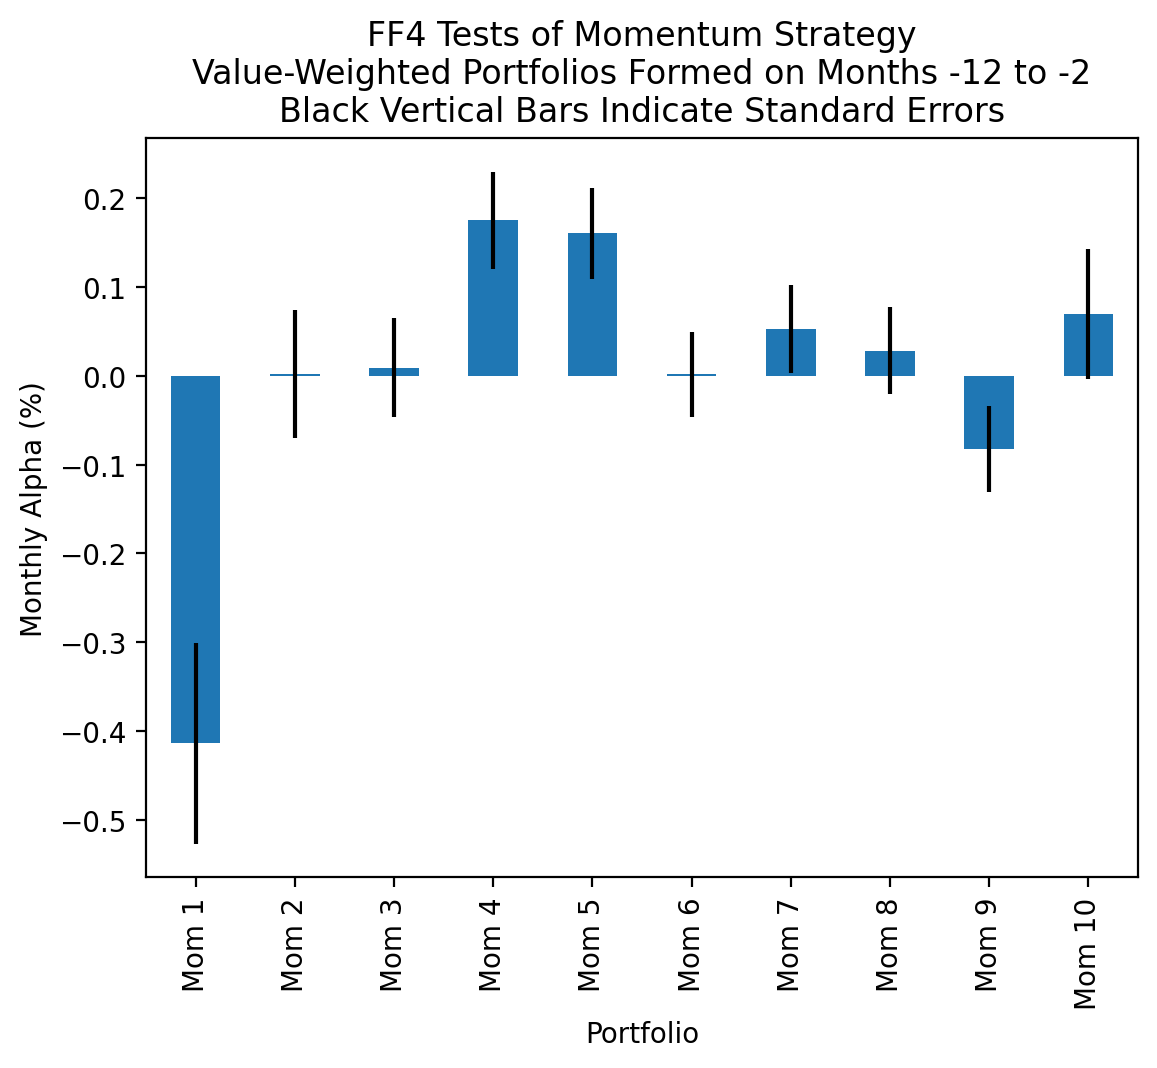

In [34]:
mom_vw.mul(100).join([ff_0[0], ff_mom[0]]).pipe(get_coefs, fun=ff4, n=10).pipe(plot_alpha)
plt.title(
    'FF4 Tests of Momentum Strategy' +
    '\nValue-Weighted Portfolios Formed on Months -12 to -2' +
    '\nBlack Vertical Bars Indicate Standard Errors'
)
plt.show()

### What are the Sharpe Ratios for these value-weighted portfolios?

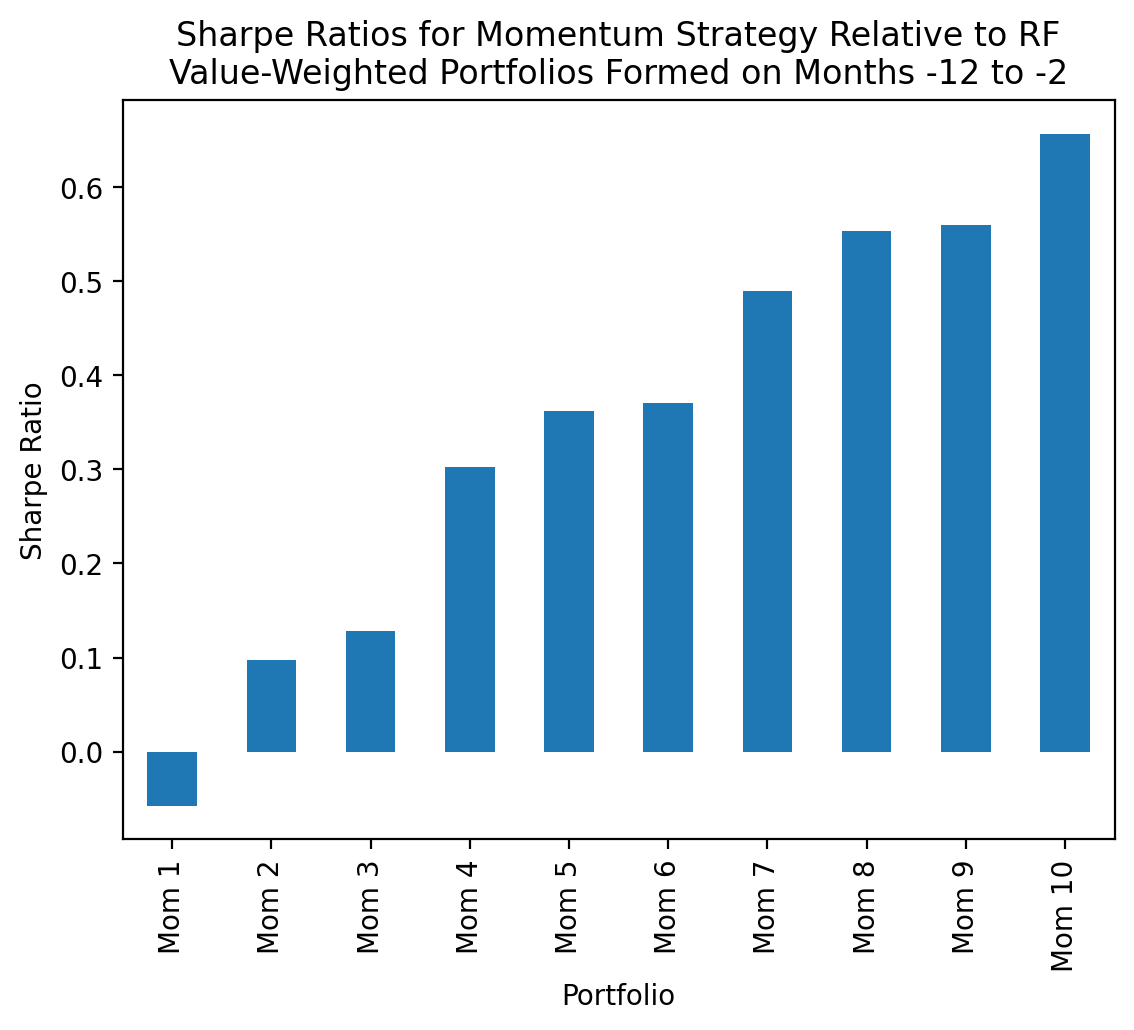

In [35]:
mom_vw.mul(100).apply(sharpe, tgt=ff_0[0]['RF'], ppy=12).plot(kind='bar')
plt.ylabel('Sharpe Ratio')
plt.title(
    'Sharpe Ratios for Momentum Strategy Relative to RF' +
    '\nValue-Weighted Portfolios Formed on Months -12 to -2'
)
plt.show()

### Implement an equal-weighted size investing strategy based on market capitalization ~~at the start of each month~~ from the previous June

***To show how to form portfolios at lower frequencies, I change this task to form portfolios once a year based on market capitalization from the previous June.***
We will assign stocks to portfolios based on market capitalization (i.e., size or the market value of equity) each June and use these portfolio assignments from July through the following June.
That is, we rank in June of year $t$, then hold them in portfolios from July in year $t$ through June in year $t+1$.

In [36]:
me_june = crsp['ME'].unstack('PERMNO').pipe(lambda x: x.loc[x.index.month == 6])

In [37]:
me_june.head()

PERMNO,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93423,93426,93428,93429,93430,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1926-06,NaN,NaN,NaN,NaN,NaN,59400.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927-06,NaN,NaN,NaN,NaN,NaN,59400.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-06,NaN,NaN,NaN,NaN,NaN,57675.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1929-06,NaN,NaN,NaN,NaN,NaN,57900.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1930-06,NaN,NaN,NaN,NaN,NaN,30900.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next we assign portfolios on these June market capitalizations.

In [38]:
me_june.apply(pd.qcut, q=10, labels=False, axis=1).head()

PERMNO,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93423,93426,93428,93429,93430,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1926-06,NaN,NaN,NaN,NaN,NaN,7.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927-06,NaN,NaN,NaN,NaN,NaN,7.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-06,NaN,NaN,NaN,NaN,NaN,7.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1929-06,NaN,NaN,NaN,NaN,NaN,6.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1930-06,NaN,NaN,NaN,NaN,NaN,6.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note, we want to use these portfolio assignments from July through June, so we need to `.shift()` with `freq='1M'`, which shifts the index one month instead of shifting the values one row.
Because we only have June data, a one-row shift is a one-year shift instead of a one-month shift.
We also need to up sample our June data to monthly date with `.resample('M')` and the `.ffill()` method.
Because we only want to fill forward 12 months, we use `.ffill(limit=12)`.

In [40]:
me_june.apply(pd.qcut, q=10, labels=False, axis=1).shift(freq='1M').resample('M').ffill(limit=12).tail()

PERMNO,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93423,93426,93428,93429,93430,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
2022-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0000,3.0000,NaN,8.0000,NaN,NaN,NaN,1.0000,NaN,9.0000
2022-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0000,3.0000,NaN,8.0000,NaN,NaN,NaN,1.0000,NaN,9.0000
2022-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0000,3.0000,NaN,8.0000,NaN,NaN,NaN,1.0000,NaN,9.0000
2022-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0000,3.0000,NaN,8.0000,NaN,NaN,NaN,1.0000,NaN,9.0000
2022-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0000,4.0000,NaN,8.0000,NaN,NaN,NaN,1.0000,NaN,9.0000


We can combine the `.apply()`, `.shift()`, `.resample()`, and `.fill()` methods into one operation when we combine the returns, trailing market capitalization, and portfolio assignments.

In [41]:
me = (
    pd.concat(
        objs=[
            ret_1m,
            crsp['ME'].unstack('PERMNO').shift(1),
            (
                me_june
                .apply(pd.qcut, q=10, labels=False, axis=1)
                .shift(freq='1M')
                .resample('M')
                .ffill(limit=12)
            )
        ],
        keys=['Return', 'Trailing ME', 'Portfolio'],
        names=['Variable'],
        axis=1
    )
    .stack('PERMNO')
    .dropna()
    .assign(Portfolio=lambda x: x['Portfolio'].astype(int) + 1)
)

In [42]:
me.head()

Variable        Return  Trailing ME  Portfolio
date    PERMNO                                
1926-07 10022   0.2400   10000.0000          5
        10030   0.0211   19402.5000          6
        10057   0.0078    4031.2500          2
        10073   0.0729    1656.0000          1
        10081   0.0156    9536.0000          4

In [43]:
me_ew = (
    me
    .groupby(['date', 'Portfolio'])
    ['Return']
    .mean()
    .unstack('Portfolio')
    .add_prefix('ME ')
)

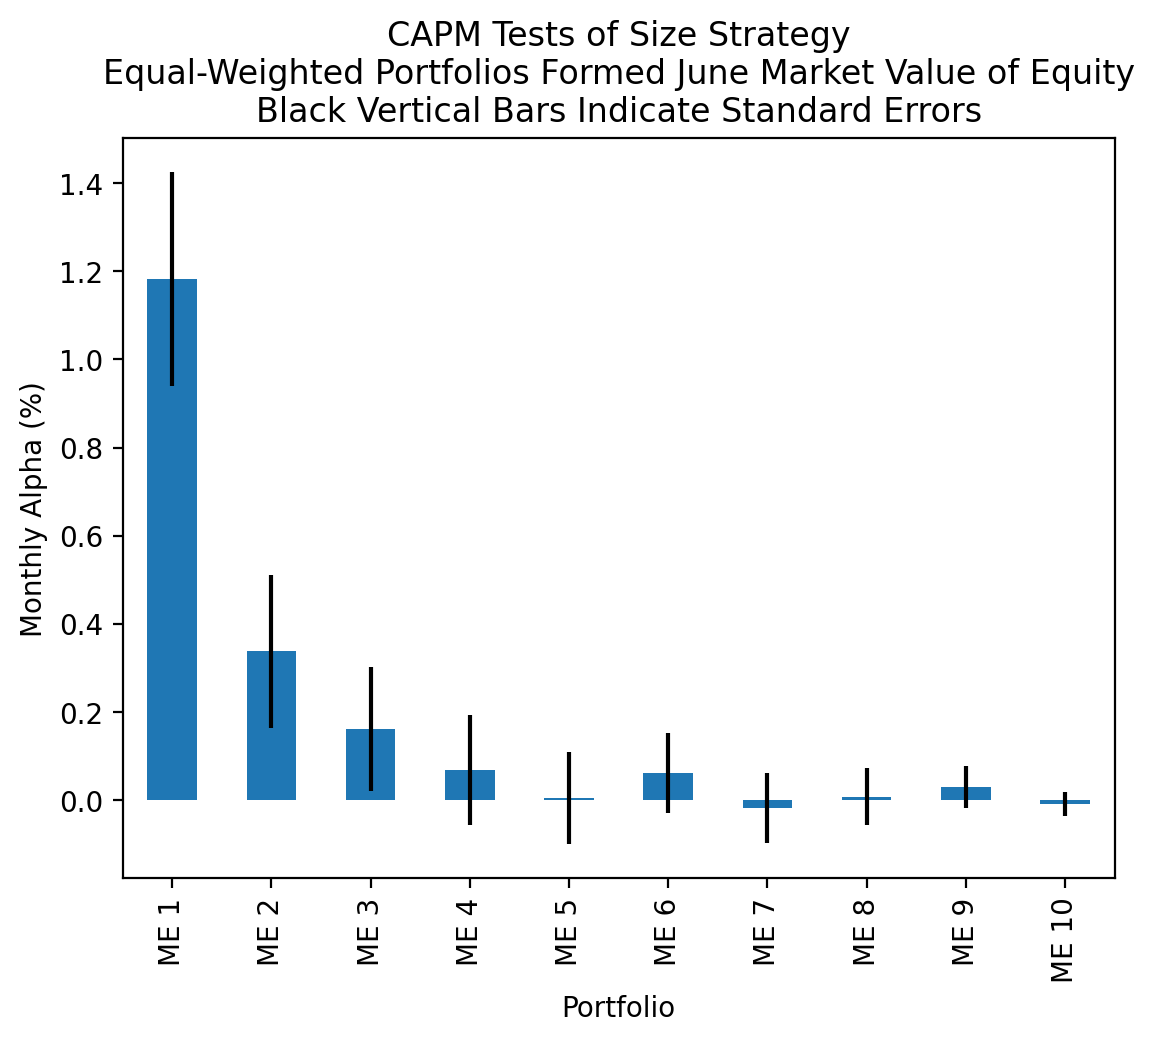

In [44]:
me_ew.mul(100).join([ff_0[0], ff_mom[0]]).pipe(get_coefs, fun=capm, n=10).pipe(plot_alpha)
plt.title(
    'CAPM Tests of Size Strategy' +
    '\nEqual-Weighted Portfolios Formed June Market Value of Equity' +
    '\nBlack Vertical Bars Indicate Standard Errors'
)
plt.show()

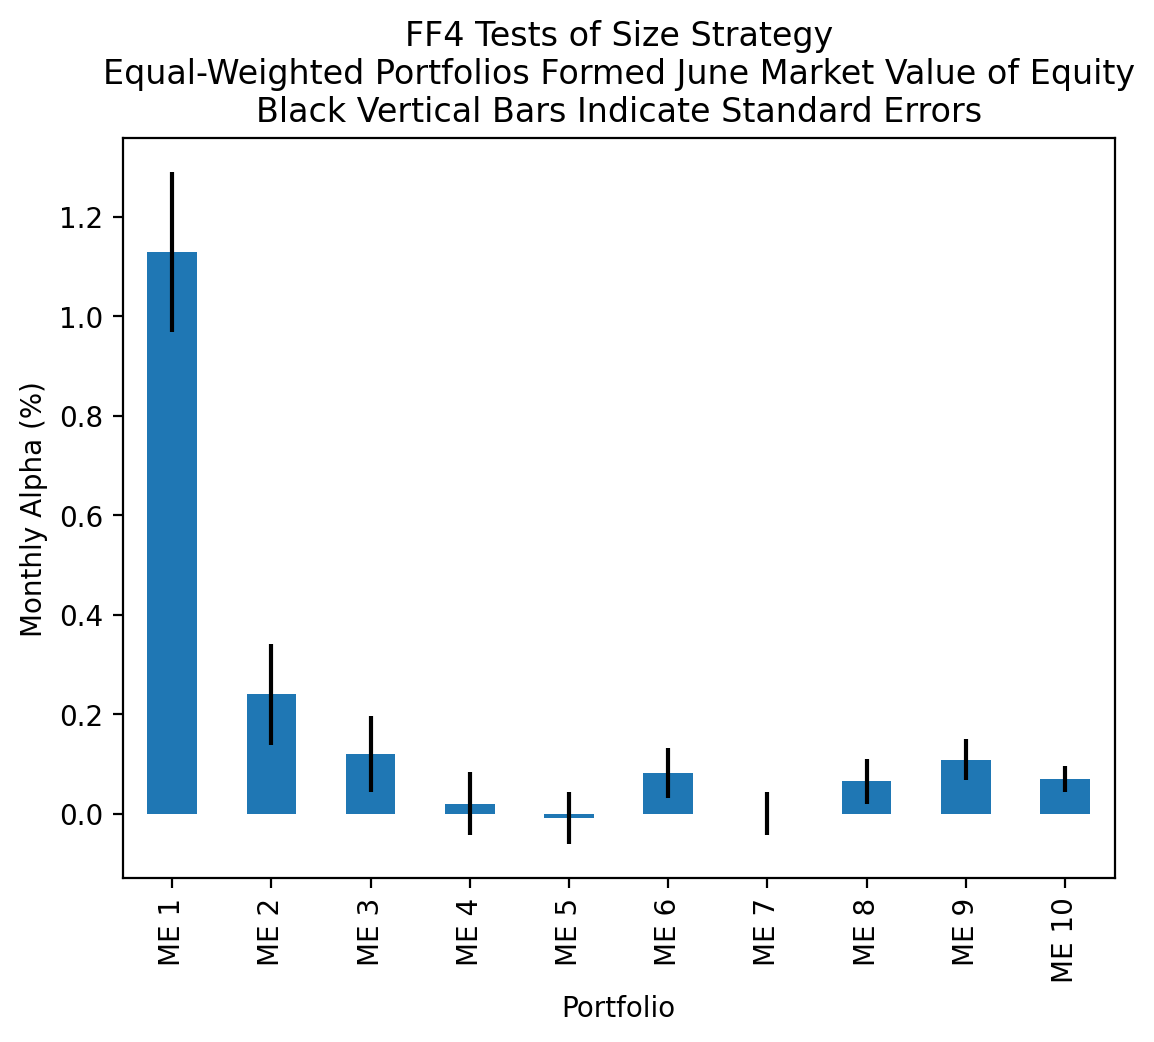

In [45]:
me_ew.mul(100).join([ff_0[0], ff_mom[0]]).pipe(get_coefs, fun=ff4, n=10).pipe(plot_alpha)
plt.title(
    'FF4 Tests of Size Strategy' +
    '\nEqual-Weighted Portfolios Formed June Market Value of Equity' +
    '\nBlack Vertical Bars Indicate Standard Errors'
)
plt.show()

If we had more time to dig into the size investing strategy, we would find:

1. The alpha is concentrated in January due to tax loss harvesting, where investors sell their losers in December and buy them back in January to earn a tax deduction
1. The smallest stocks in the ME 1 portfolio are tiny, making them impractical for institutional investors and allowing the anomaly to persist (because these stocks are small and illiquid, the size factor does not try to explain away their alpha)

We can quickly see the point 2 above by plotting the mean marker capitalization for each portfolio.
This analysis is "quick and dirty" because we have not inflation adjusted these values.
Still, we quickly see that the ME 10 stocks are 1,000 times larger than the ME 1 stocks, on average.

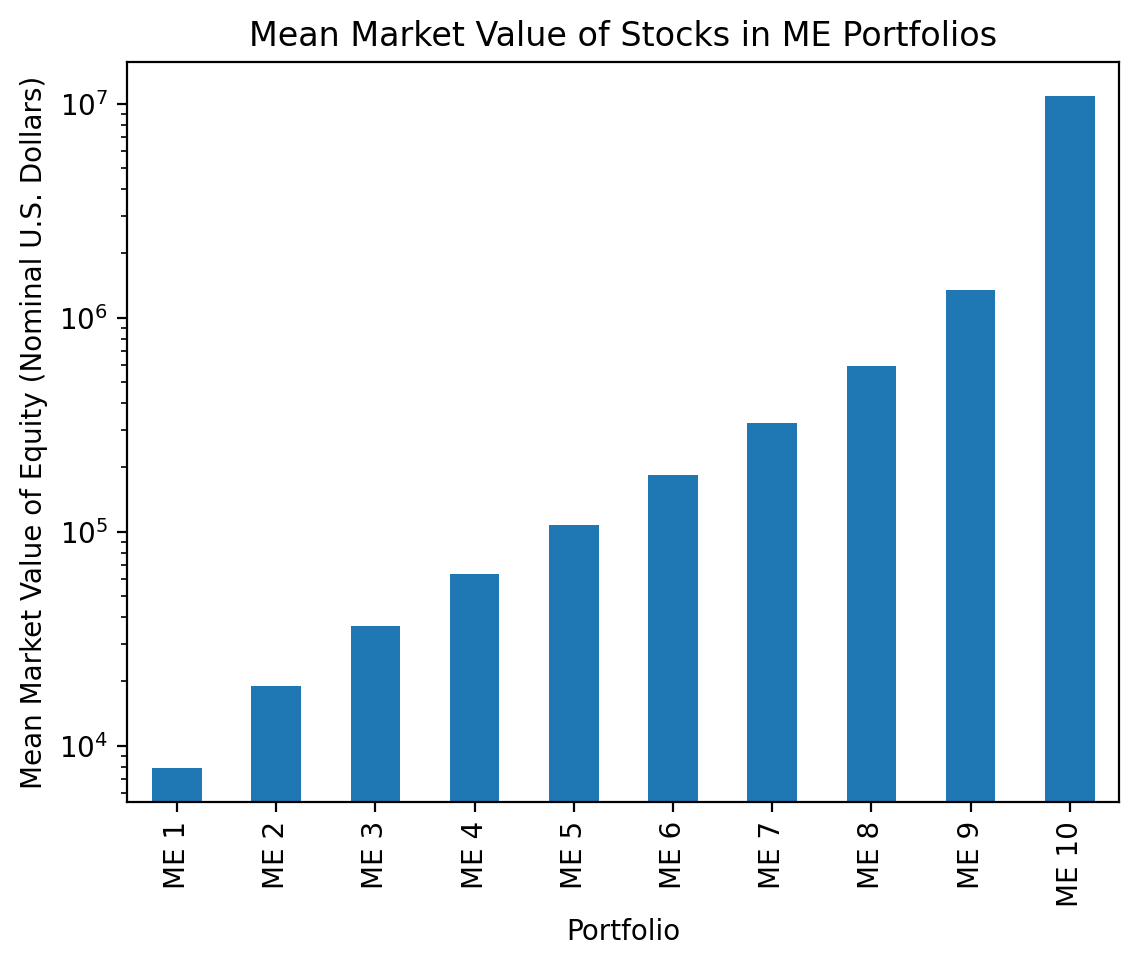

In [46]:
(
    me
    .groupby(['Portfolio', 'date'])
    ['Trailing ME']
    .mean()
    .unstack('Portfolio')
    .add_prefix('ME ')
    .mean()
    .plot(kind='bar')
)
plt.semilogy()
plt.ylabel('Mean Market Value of Equity (Nominal U.S. Dollars)')
plt.title('Mean Market Value of Stocks in ME Portfolios')
plt.show()

### Implement a value-weighted size investing strategy based on market capitalization ~~at the start of each month~~ from the previous June

With value-weighted portfolios, the size investing strategy alphas disappear!
The alpha disappears because value-weighted portfolios down weight the smallest of the smallest stocks that made the size investing strategy appear to be returns not explained by risk.

In [47]:
me_vw = (
    me
    .groupby(['date', 'Portfolio'])
    .apply(lambda x: np.average(a=x['Return'], weights=x['Trailing ME']))
    .unstack('Portfolio')
    .add_prefix('ME ')
)

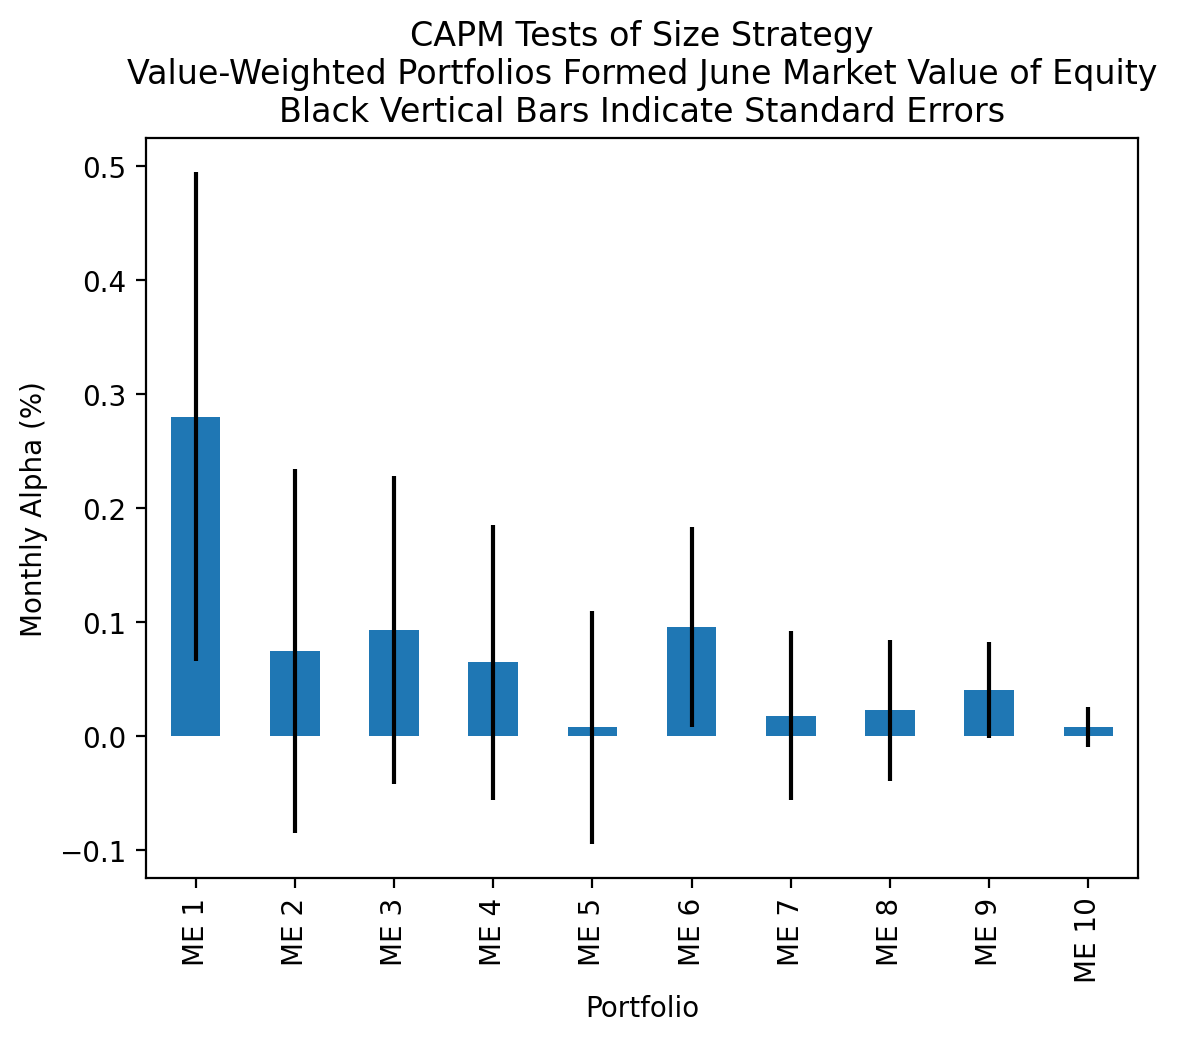

In [48]:
me_vw.mul(100).join([ff_0[0], ff_mom[0]]).pipe(get_coefs, fun=capm, n=10).pipe(plot_alpha)
plt.title(
    'CAPM Tests of Size Strategy' +
    '\nValue-Weighted Portfolios Formed June Market Value of Equity' +
    '\nBlack Vertical Bars Indicate Standard Errors'
)
plt.show()

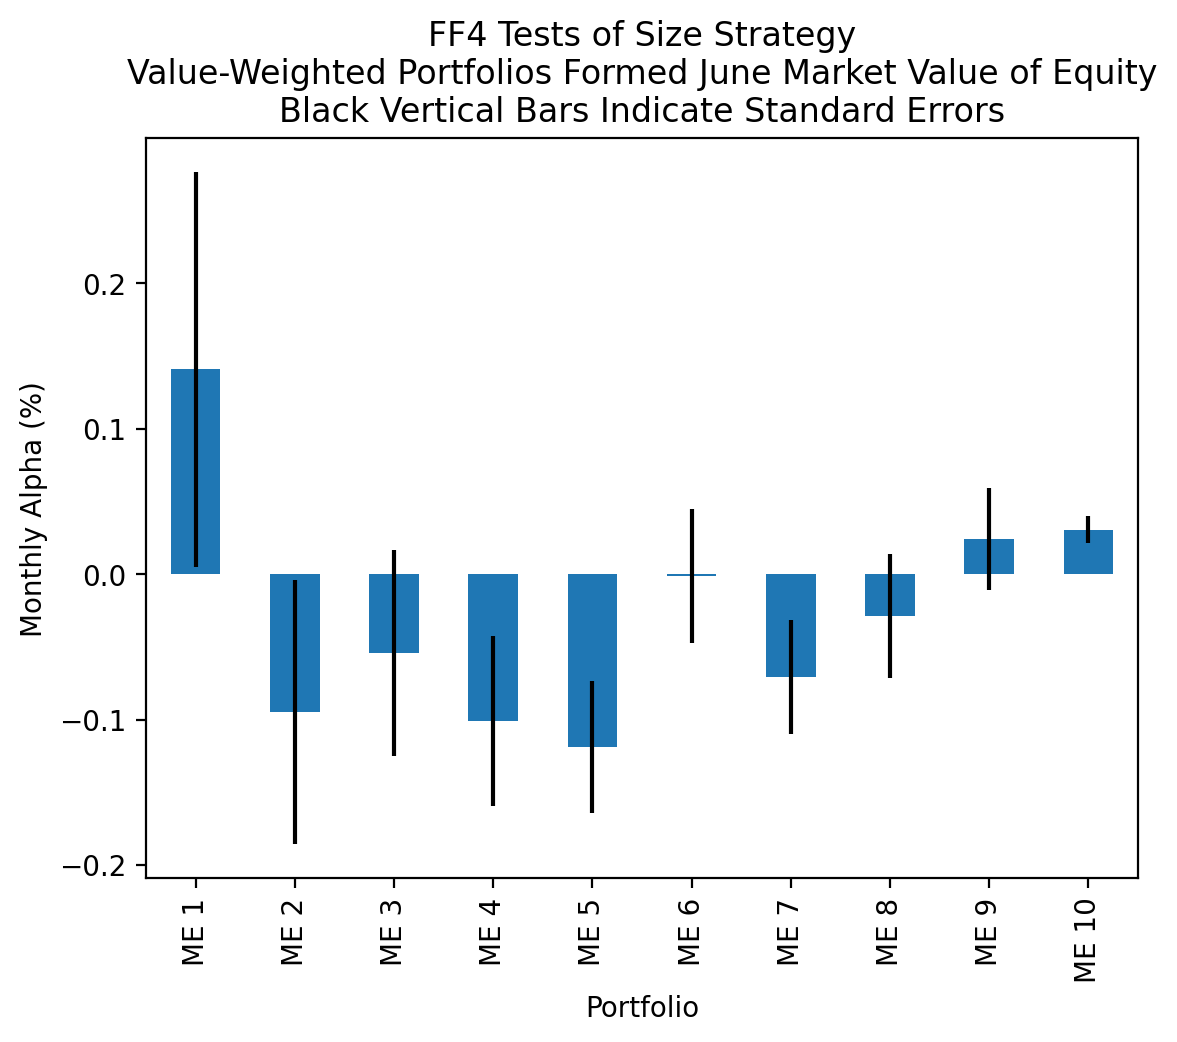

In [49]:
me_vw.mul(100).join([ff_0[0], ff_mom[0]]).pipe(get_coefs, fun=ff4, n=10).pipe(plot_alpha)
plt.title(
    'FF4 Tests of Size Strategy' +
    '\nValue-Weighted Portfolios Formed June Market Value of Equity' +
    '\nBlack Vertical Bars Indicate Standard Errors'
)
plt.show()